c:\Users\jakob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\Users\jakob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


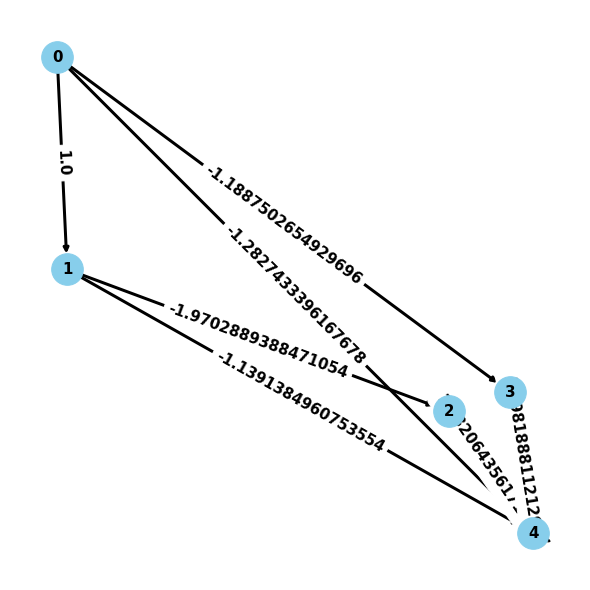

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
from pyvis.network import Network

from DAG import DAG

dag = DAG(n = 5, roots = 1, strength=2, precalculate_paths = True)
dag.plot()

In [20]:
dag.get_varsortability(analytical=True)

{'analytical': 0.9230769230769231}

0.6878464737055737

In [12]:
# dag.precalculate_paths = False
from time import time
t = time()
sim = dag.get_simulated_var(100000)
print("time:", time() - t)
t = time()
ana = dag.get_analytical_var()
print("time:", time() - t)

for i in range(dag.size):
    print("simulated", i, ":",round(sim[i]), "| analytical", ":", round(ana[i]))

print("")
varsort = dag.get_varsortability(analytical = True, simulated = True, N = 100000)
print("varsortability:", varsort)

time: 0.12483930587768555
time: 17.275866746902466
simulated 0 : 1 | analytical : 1
simulated 1 : 2 | analytical : 2
simulated 2 : 5 | analytical : 5
simulated 3 : 42 | analytical : 42
simulated 4 : 232 | analytical : 230
simulated 5 : 6 | analytical : 6
simulated 6 : 930 | analytical : 921
simulated 7 : 2480 | analytical : 2455
simulated 8 : 9059 | analytical : 8968
simulated 9 : 115241 | analytical : 114089
simulated 10 : 28948 | analytical : 28660
simulated 11 : 1038738 | analytical : 1028378
simulated 12 : 966751 | analytical : 957098
simulated 13 : 12955572 | analytical : 12826260
simulated 14 : 45700085 | analytical : 45243778

varsortability: {'analytical': 1.0, 'simulated': 1.0}


$V_a = \sum^{nodes}_i\sum_{j,k}\prod^{path_{j}}_j\prod^{path_{ia}}_k W_j W_kV_i + V_a$

In [22]:
# genetic algorithm

start_adj = np.array([[0,1,0,1,1],[0,0,1,1,1],[0,0,0,1,1],[0,0,0,0,0], [0,0,0,0,0]])

start_dags = [DAG(n = 5, roots = 1, strength=2, precalculate_paths = False, adjacency_matrix = start_adj) for _ in range(11)]


for i in range(20):
    print("")
    print("generation", i)
    start_dags = sorted(start_dags, key = lambda x: x.get_varsortability(analytical = False, simulated = True, N = 100000)["simulated"], reverse = False)
    start_dags = start_dags[:5]
    for j in range(5):
        start_dags.append(start_dags[j].mutate())

    new = DAG(n = 5, roots = 1, strength=2, precalculate_paths = False, adjacency_matrix = start_adj)
    start_dags.append(new.mutate())

    for j in range(1):
        print("varsortability:", start_dags[j].get_varsortability(analytical = False, simulated = True, N = 100000))
        print("continous_varsortability:", start_dags[j].get_continous_varsortability(analytical = False, simulated = True, N = 100000)["simulated"])



generation 0
varsortability: {'simulated': 1.0}
continous_varsortability: 0.2775623742868404

generation 1
varsortability: {'simulated': 0.9333333333333333}
continous_varsortability: 0.22891463079699428

generation 2
varsortability: {'simulated': 0.9333333333333333}
continous_varsortability: 0.2289371369626606

generation 3
varsortability: {'simulated': 0.9333333333333333}
continous_varsortability: 0.22944086074004627

generation 4
varsortability: {'simulated': 0.9333333333333333}
continous_varsortability: 0.22911275294764907

generation 5
varsortability: {'simulated': 0.7857142857142857}
continous_varsortability: 0.15287501805540799

generation 6
varsortability: {'simulated': 0.9285714285714286}
continous_varsortability: 0.15193300765256793

generation 7
varsortability: {'simulated': 0.9285714285714286}
continous_varsortability: 0.1532914923179485

generation 8
varsortability: {'simulated': 0.9285714285714286}
continous_varsortability: 0.15179670680908097

generation 9
varsortability

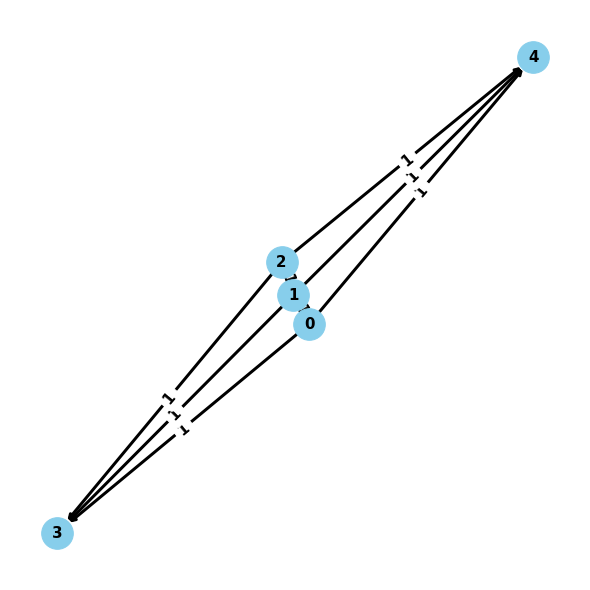

In [12]:
start_adj = np.array([[0,1,0,1,1],[0,0,1,1,1],[0,0,0,1,1],[0,0,0,0,0], [0,0,0,0,0]])

sd = DAG(n = 5, roots = 1, strength=3, precalculate_paths = False, adjacency_matrix = start_adj)
sd.plot()

In [13]:
print(sd.adjacency_matrix,"\n",  m.adjacency_matrix)

[[0 1 0 1 1]
 [0 0 1 1 1]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]] 
 [[ 0  1  0  1  1]
 [ 0  0  0  1 -1]
 [ 0  0  0  1  1]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


In [17]:
m.strength

2

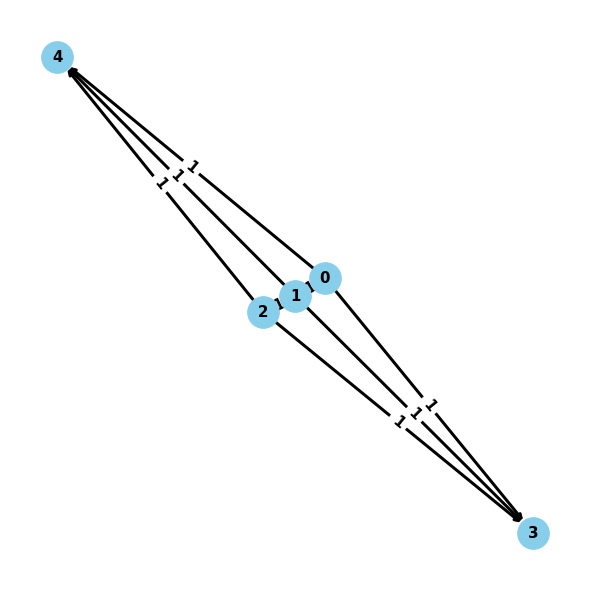

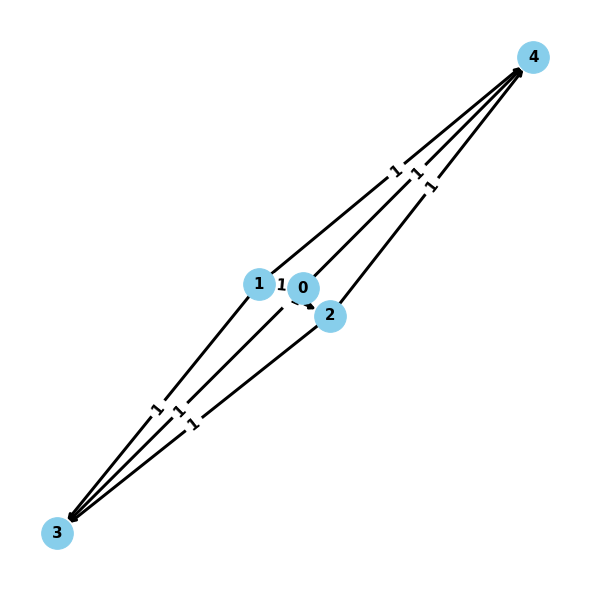

In [16]:
m = sd.mutate()

m.plot()

m2 = m.mutate()

m.plot()

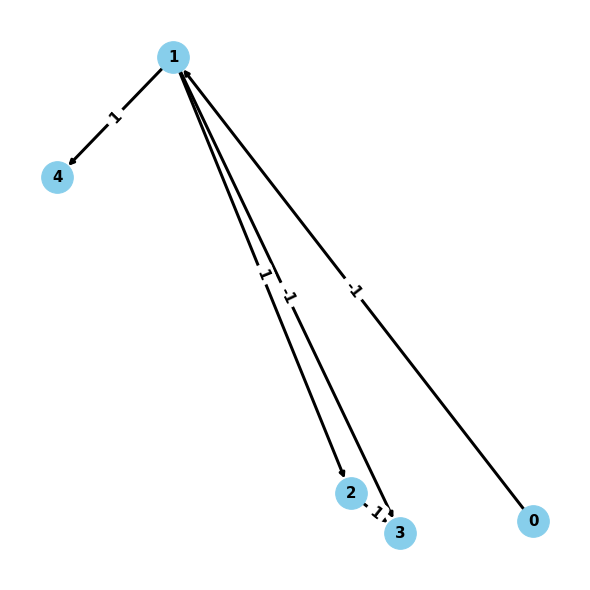

In [24]:
start_dags[2].plot()
# print(start_dags[0].get_analytical_var())
# print(start_dags[0].get_simulated_var(1000000))

In [28]:
start_dags[0].get_varsortability(analytical = True, simulated = True, N = 100)

{'analytical': 0.5454545454545454, 'simulated': 0.4090909090909091}

c:\Users\jakob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
c:\Users\jakob\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


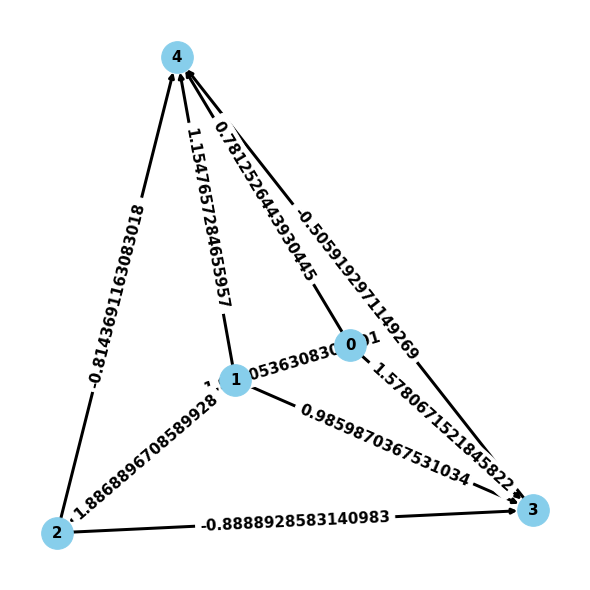

[ 1.          4.98023899 18.73140699  2.307556    1.39656518]


In [20]:
start_dags[0].plot()
print(start_dags[0].get_analytical_var())
